In [34]:
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
from tqdm import tqdm
from torch import nn
from sklearn.metrics import accuracy_score
from umap import UMAP

In [2]:
from cassava.transforms import get_test_transforms

In [3]:
%matplotlib inline

In [4]:
# metrics = context.catalog.load('train_metrics')

2020-12-08 12:17:11,903 - kedro.io.data_catalog - INFO - Loading data from `train_metrics` (PickleDataSet)...


In [18]:
# metrics['last_epoch']

In [19]:
# plt.figure()
# sns.lineplot(data=metrics['train_losses'], label='train_loss')
# plt.show()

# plt.figure()
# sns.lineplot(data=metrics['validation_losses'], label='val_Loss', color='orange')
# plt.show()

In [ ]:
train_indices, val_indices = context.catalog.load('')

In [20]:
val_scores = context.catalog.load('val_scores')
val_scores

2020-12-08 12:17:33,485 - kedro.io.data_catalog - INFO - Loading data from `val_scores` (PickleDataSet)...


{'accuracy': 0.6619158878504673,
 'confusion_matrix': array([[  39,   37,    3,    3,   32],
        [  17,   71,   12,    4,   10],
        [   1,    7,   14,    5,   14],
        [ 126,  276,  411, 2606,  357],
        [  34,   47,   37,   14,  103]]),
 'f1_score': 0.7462869204127027}

In [21]:
#!curl https://raw.githubusercontent.com/DTrimarchi10/confusion_matrix/master/cf_matrix.py -O cf_matrix.py

In [22]:
from cf_matrix import make_confusion_matrix

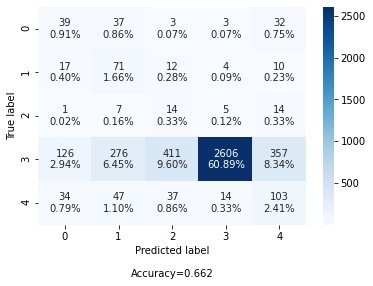

In [23]:
make_confusion_matrix(val_scores['confusion_matrix'])

In [178]:
model = context.catalog.load('model')

2020-12-08 13:20:06,397 - kedro.io.data_catalog - INFO - Loading data from `model` (TorchLocalModel)...


In [179]:
model.eval()

LeafDoctorModel(
  (trunk): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [27]:
train_images_torch = context.catalog.load('train_images_torch')

2020-12-08 12:17:52,620 - kedro.io.data_catalog - INFO - Loading data from `train_images_torch` (ImageFolderDataSet)...


In [28]:
train_images_torch.transform = get_test_transforms()

In [29]:
unnorm = UnNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Predict on random image

In [31]:
train_images_torch.transform = get_test_transforms()

In [35]:
def predict(model, x, invtemp=1):
    logits = model.forward(x)
    probabilities = nn.functional.softmax(invtemp*logits, dim=1)
    return probabilities

def pred_label(model, x, invtemp=1):
    return torch.max(predict(model, x, invtemp=invtemp), 1)[1]

def predict_diff_temps(model, x, invtemps):
    logits = model.forward(x)
    
    return {
        temp: nn.functional.softmax(temp*logits, dim=1) for temp in invtemps
    }


/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


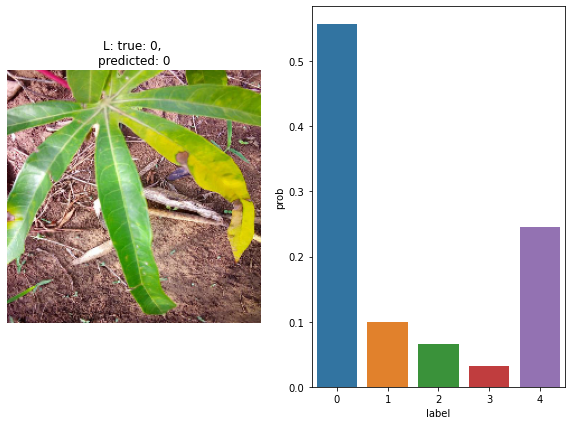

In [52]:
random_idx = np.random.choice(range(len(train_images_torch)))
image, label = train_images_torch[random_idx]

probabilities = predict(model, image.unsqueeze(0), invtemp=0.5)[0]
prediction = pred_label(model, image.unsqueeze(0)).item()

plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
plot_image(unnorm(image), label=f"true: {label}, \npredicted: {prediction}")
plt.subplot(1, 2, 2)
sns.barplot(y=probabilities.detach().numpy(), x=list(range(5)))
plt.xlabel('label')
plt.ylabel('prob')
plt.show()

# Calibration curves

In [53]:
from sklearn.calibration import calibration_curve

/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [64]:
from cassava.utils import DatasetFromSubset

In [65]:
indices = np.random.choice(range(len(train_images_torch)), 2000)

In [66]:
train_images_torch.transform = None

In [67]:
dataset = DatasetFromSubset(torch.utils.data.Subset(train_images_torch, indices=indices),
                      transform=get_test_transforms())
loader = torch.utils.data.DataLoader(dataset, batch_size=10)

In [68]:
predictions = {}
true_labels = []

invtemps = [0.5, 1, 5, 10, 100]

for temp in invtemps:
    predictions[temp] = []

model.eval()
for images, labels in tqdm(loader):
    preds =  predict_diff_temps(model, images, invtemps)
    for temp in invtemps:
        predictions[temp] += preds[temp].tolist()
    true_labels += labels.tolist()

100%|██████████| 200/200 [00:57<00:00,  3.46it/s]


In [69]:
for temp in invtemps:
    predictions[temp] = np.array(predictions[temp])
true_labels = np.array(true_labels)

In [70]:
true_labels[:10]

array([3, 4, 3, 3, 3, 3, 3, 4, 2, 2])

In [71]:
predictions[1][:10]

array([[1.23054860e-02, 1.74779873e-02, 1.93011597e-01, 2.34627351e-01,
        5.42577565e-01],
       [2.30069831e-02, 3.40038091e-02, 6.32948130e-02, 7.21666098e-01,
        1.58028230e-01],
       [1.72814175e-01, 4.02522869e-02, 3.71545330e-02, 8.10056478e-02,
        6.68773353e-01],
       [2.52339407e-04, 1.10652647e-03, 5.17459571e-01, 4.79788572e-01,
        1.39294530e-03],
       [2.11733186e-05, 1.86412755e-04, 4.24950122e-04, 9.98858213e-01,
        5.09228674e-04],
       [1.18044519e-03, 9.91294277e-04, 4.03999165e-02, 9.47673082e-01,
        9.75517277e-03],
       [4.02642036e-05, 5.61760608e-05, 3.34530196e-05, 9.99051392e-01,
        8.18673288e-04],
       [5.84151894e-02, 6.05114661e-02, 8.08268115e-02, 2.82015093e-02,
        7.72045016e-01],
       [6.70650101e-04, 6.26086211e-03, 9.76315677e-01, 4.14628536e-03,
        1.26066115e-02],
       [1.17340001e-04, 1.08041125e-03, 6.26439214e-01, 3.71324837e-01,
        1.03823189e-03]])

[0.8705, 0.8705, 0.8705, 0.8705, 0.8705]


<ipython-input-72-dc36d989ea84>:11: UserWarning: Attempting to set identical bottom == top == 0.8705 results in singular transformations; automatically expanding.
  plt.ylim(min(accuracies), max(accuracies))


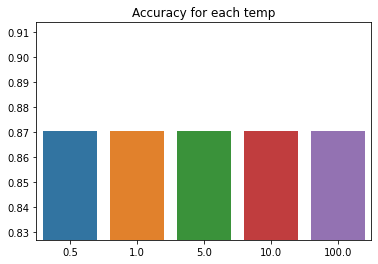

In [72]:
accuracies = []
for temp in invtemps:
    pred_probs = predictions[temp]
    pred_labels = np.argmax(pred_probs, 1)
    
    accuracies.append(accuracy_score(true_labels, pred_labels))
plt.figure()
sns.barplot(x=invtemps, y=accuracies)
plt.title('Accuracy for each temp')
plt.ylim(min(accuracies), max(accuracies))
plt.show()

/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


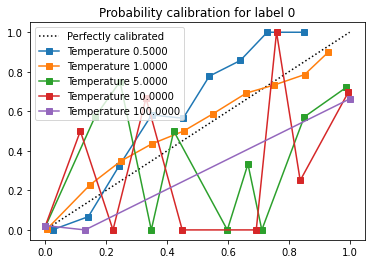

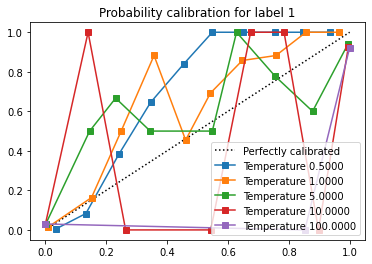

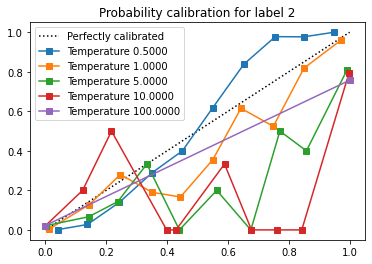

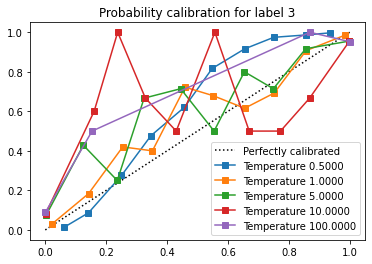

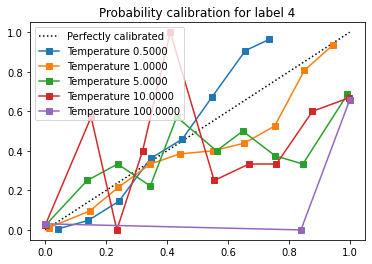

In [73]:
for label in [0, 1, 2, 3, 4]:
    plt.figure()
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    plt.title(f'Probability calibration for label {label}')
    true_label = (true_labels == label)
    
    for temp in invtemps:
        pred_prob = predictions[temp][:, label]
    
        fraction_of_positives, mean_predicted_value = \
                calibration_curve(true_label, pred_prob, n_bins=10)

        plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f"Temperature {temp:0.4f}")
    plt.legend()
    plt.show()